## Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
import numpy as np
from scipy.signal import hilbert
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, LSTM


## Load the Dataset

In [2]:
emotion_map = {
    '01': 'Netral',
    '02': 'Senang',
    '03': 'Terkejut',
    '04': 'Jijik',
    '05': 'Kecewa'
}

In [3]:
paths = []
actors = []
genders = []
emotions = []
intensities = []
repetitions = []

base_dir = 'dataset/IndoWaveSentiment/'
for actor_folder in os.listdir(base_dir):
    actor_path = os.path.join(base_dir, actor_folder)
    if os.path.isdir(actor_path):
        for filename in os.listdir(actor_path):
            if filename.endswith('.wav'):
                paths.append(os.path.join(actor_path, filename))
                parts = filename.replace('.wav', '').split('-')
                actor = parts[0]
                emotion = parts[1]
                intensity = parts[2]
                repetition = parts[3]
                actors.append(actor)
                genders.append('Pria' if int(actor) % 2 == 1 else 'Wanita')
                emotions.append(emotion_map[emotion])
                intensities.append('Normal' if intensity == '01' else 'Strong')
                repetitions.append(repetition)

In [4]:
len(paths)

300

In [5]:
paths[:5]

['dataset/IndoWaveSentiment/Actor_01\\01-01-01-01.wav',
 'dataset/IndoWaveSentiment/Actor_01\\01-01-01-02.wav',
 'dataset/IndoWaveSentiment/Actor_01\\01-01-01-03.wav',
 'dataset/IndoWaveSentiment/Actor_01\\01-01-02-01.wav',
 'dataset/IndoWaveSentiment/Actor_01\\01-01-02-02.wav']

In [6]:
actor[:5]

'10'

In [7]:
genders[:5]

['Pria', 'Pria', 'Pria', 'Pria', 'Pria']

In [8]:
emotions[:5]

['Netral', 'Netral', 'Netral', 'Netral', 'Netral']

In [9]:
intensities[:5]

['Normal', 'Normal', 'Normal', 'Strong', 'Strong']

In [10]:
repetitions[:5]

['01', '02', '03', '01', '02']

In [4]:
## Create a dataframe
df = pd.DataFrame({
    'path': paths,
    'aktor': actors,
    'gender': genders,
    'emosi': emotions,
    'intensitas': intensities,
    'repetisi': repetitions
})
df.head()

,path,aktor,gender,emosi,intensitas,repetisi
0,dataset/IndoWaveSentiment/Actor_01\01-01-01-01...,01,Pria,Netral,Normal,01
1,dataset/IndoWaveSentiment/Actor_01\01-01-01-02...,01,Pria,Netral,Normal,02
2,dataset/IndoWaveSentiment/Actor_01\01-01-01-03...,01,Pria,Netral,Normal,03
3,dataset/IndoWaveSentiment/Actor_01\01-01-02-01...,01,Pria,Netral,Strong,01
4,dataset/IndoWaveSentiment/Actor_01\01-01-02-02...,01,Pria,Netral,Strong,02


In [12]:
df['path'].value_counts()

path
dataset/IndoWaveSentiment/Actor_01\01-01-01-01.wav    1
dataset/IndoWaveSentiment/Actor_07\07-05-01-03.wav    1
dataset/IndoWaveSentiment/Actor_07\07-05-01-01.wav    1
dataset/IndoWaveSentiment/Actor_07\07-04-02-03.wav    1
dataset/IndoWaveSentiment/Actor_07\07-04-02-02.wav    1
                                                     ..
dataset/IndoWaveSentiment/Actor_04\04-02-02-01.wav    1
dataset/IndoWaveSentiment/Actor_04\04-02-01-03.wav    1
dataset/IndoWaveSentiment/Actor_04\04-02-01-02.wav    1
dataset/IndoWaveSentiment/Actor_04\04-02-01-01.wav    1
dataset/IndoWaveSentiment/Actor_10\10-05-02-03.wav    1
Name: count, Length: 300, dtype: int64

In [13]:
df['aktor'].value_counts()

aktor
01    30
02    30
03    30
04    30
05    30
06    30
07    30
08    30
09    30
10    30
Name: count, dtype: int64

In [14]:
df['gender'].value_counts()

gender
Pria      150
Wanita    150
Name: count, dtype: int64

In [15]:
df['emosi'].value_counts()

emosi
Netral      60
Senang      60
Terkejut    60
Jijik       60
Kecewa      60
Name: count, dtype: int64

In [16]:
df['intensitas'].value_counts()

intensitas
Normal    150
Strong    150
Name: count, dtype: int64

In [17]:
df['repetisi'].value_counts()

repetisi
01    100
02    100
03    100
Name: count, dtype: int64

## Exploratory Data Analysis

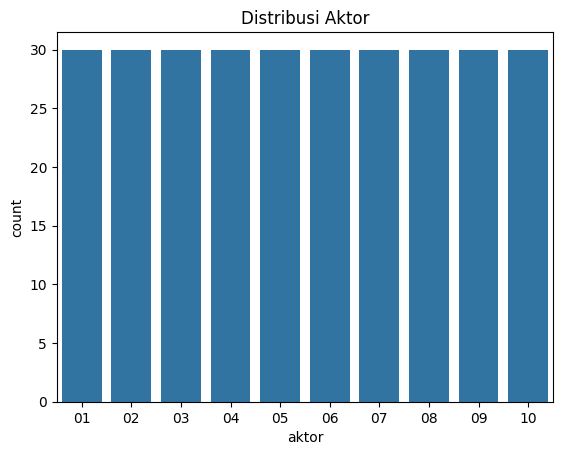

In [18]:
sns.countplot(data=df, x='aktor')
plt.title('Distribusi Aktor')
plt.show()

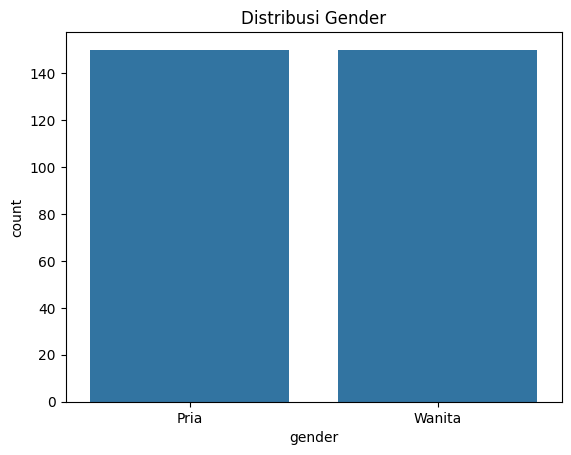

In [19]:
sns.countplot(data=df, x='gender')
plt.title('Distribusi Gender')
plt.show()

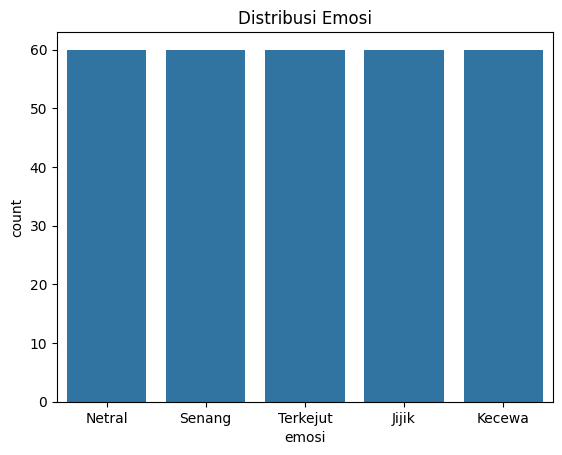

In [20]:
sns.countplot(data=df, x='emosi')
plt.title('Distribusi Emosi')
plt.show()

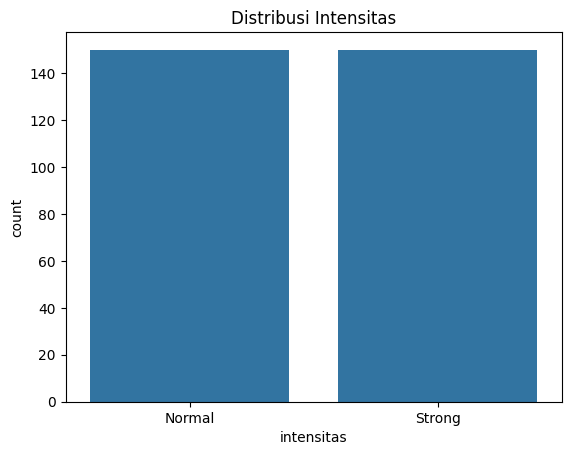

In [21]:
sns.countplot(data=df, x='intensitas')
plt.title('Distribusi Intensitas')
plt.show()

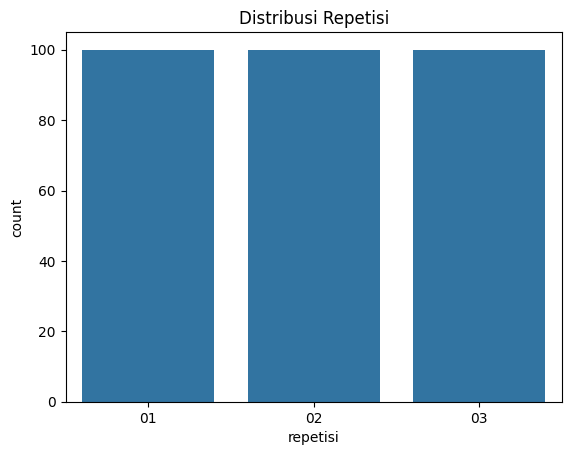

In [22]:
sns.countplot(data=df, x='repetisi')
plt.title('Distribusi Repetisi')
plt.show()

In [5]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

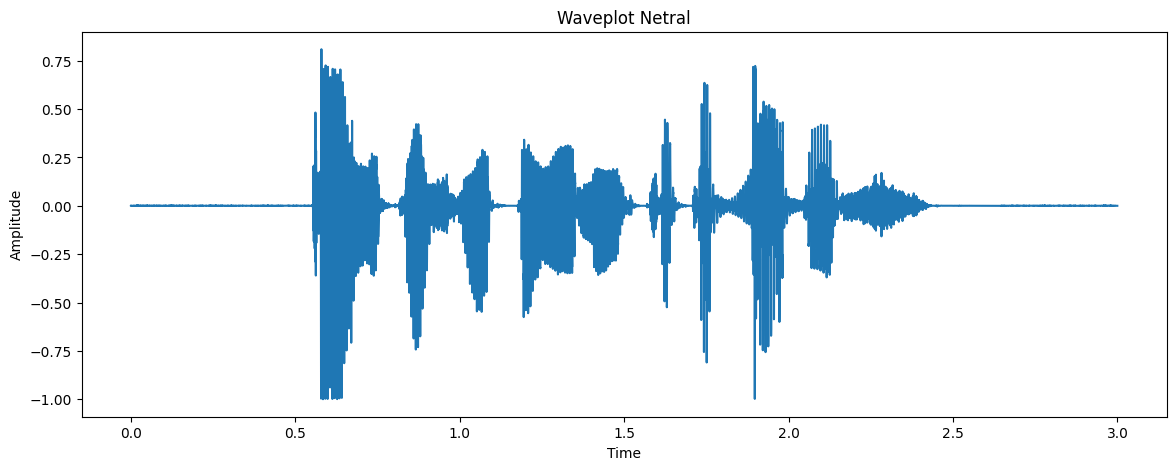

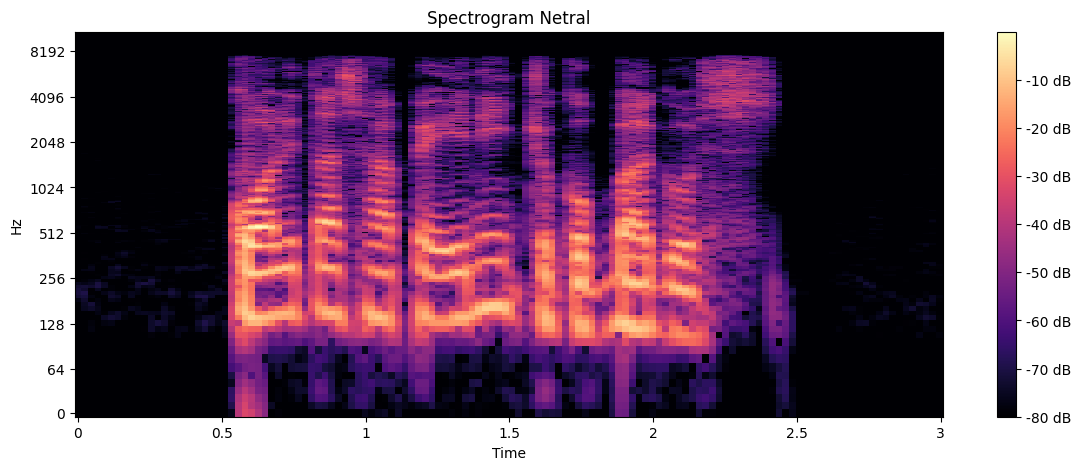

In [24]:
emotion = 'Netral'
paths = np.array(df['path'][df['emosi'] == emotion])[0]

# Load the audio data and get the sampling rate
data, sampling_rate = librosa.load(paths)

# Waveplot
plt.figure(figsize=(14, 5))
plt.title('Waveplot Netral')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(np.arange(len(data)) / sampling_rate, data)
plt.show()

# Spectrogram
plt.figure(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Netral')
plt.show()
Audio(paths)

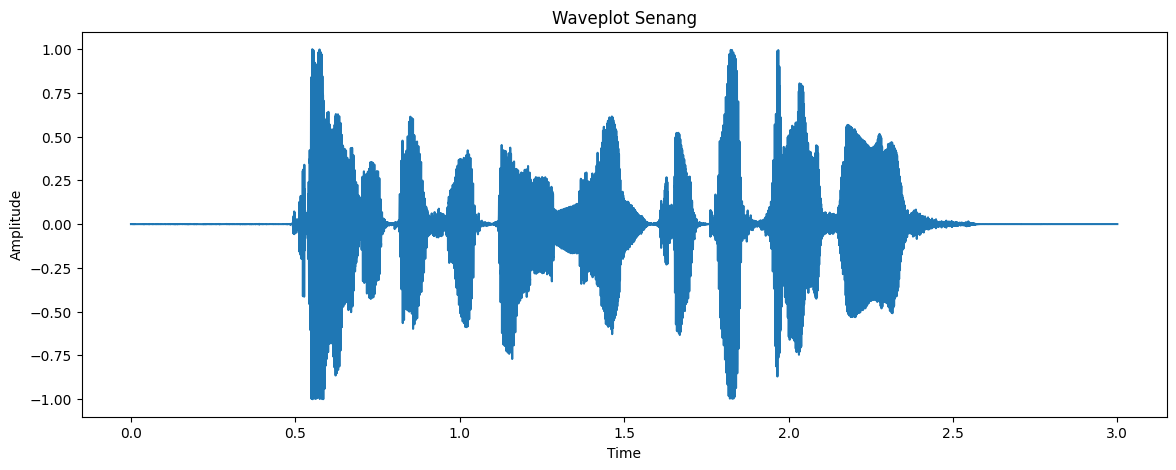

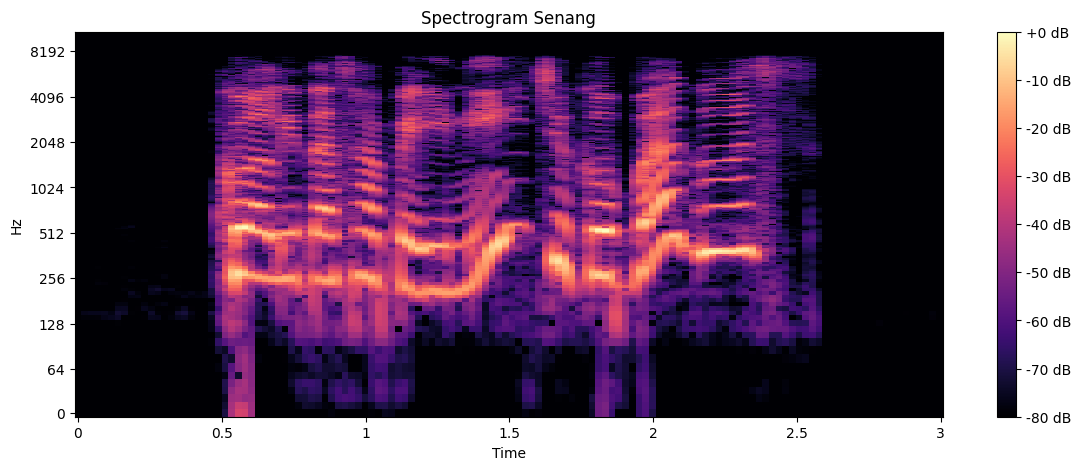

In [25]:
emotion = 'Senang'
paths = np.array(df['path'][df['emosi'] == emotion])[10]

# Load the audio data and get the sampling rate
data, sampling_rate = librosa.load(paths)

# Waveplot
plt.figure(figsize=(14, 5))
plt.title('Waveplot Senang')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(np.arange(len(data)) / sampling_rate, data)
plt.show()

# Spectrogram
plt.figure(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Senang')
plt.show()
Audio(paths)

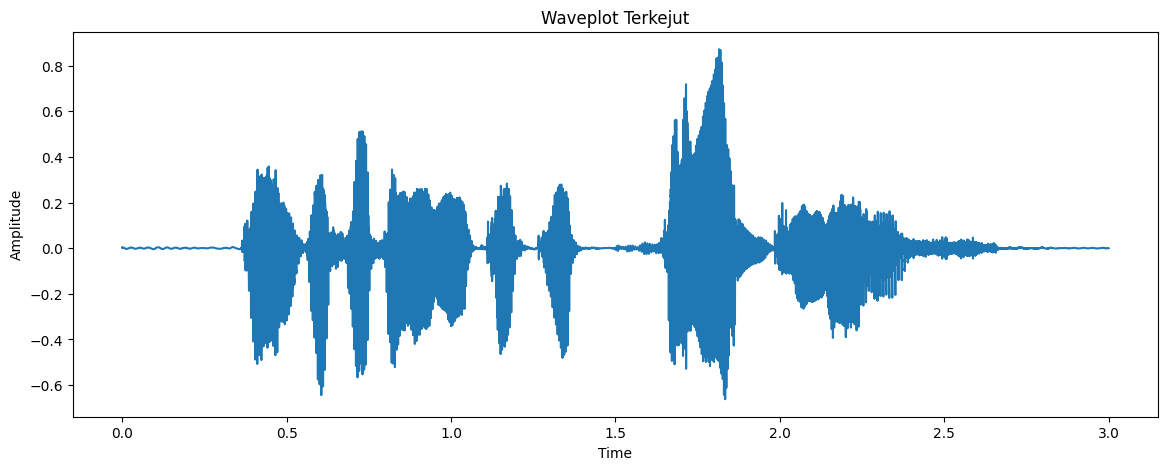

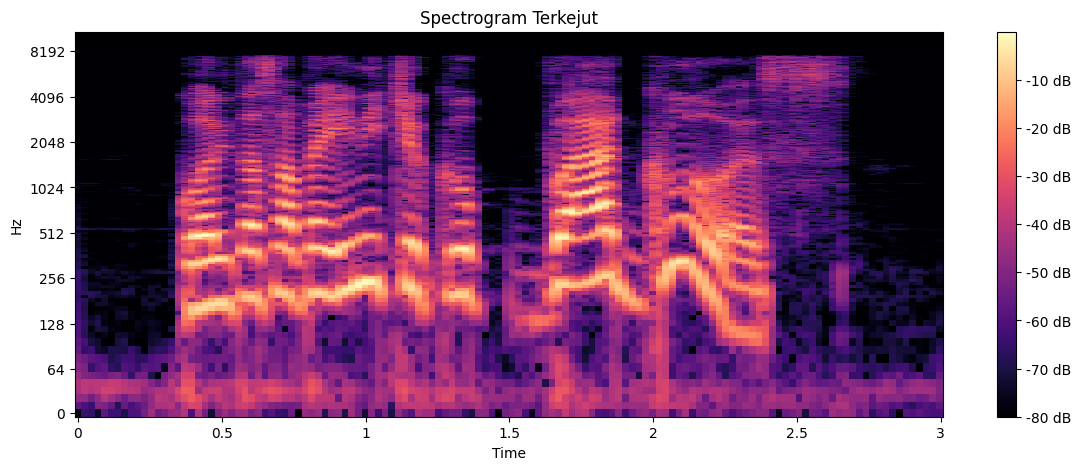

In [26]:
emotion = 'Terkejut'
paths = np.array(df['path'][df['emosi'] == emotion])[16]

# Load the audio data and get the sampling rate
data, sampling_rate = librosa.load(paths)

# Waveplot
plt.figure(figsize=(14, 5))
plt.title('Waveplot Terkejut')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(np.arange(len(data)) / sampling_rate, data)
plt.show()

# Spectrogram
plt.figure(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Terkejut')
plt.show()
Audio(paths)

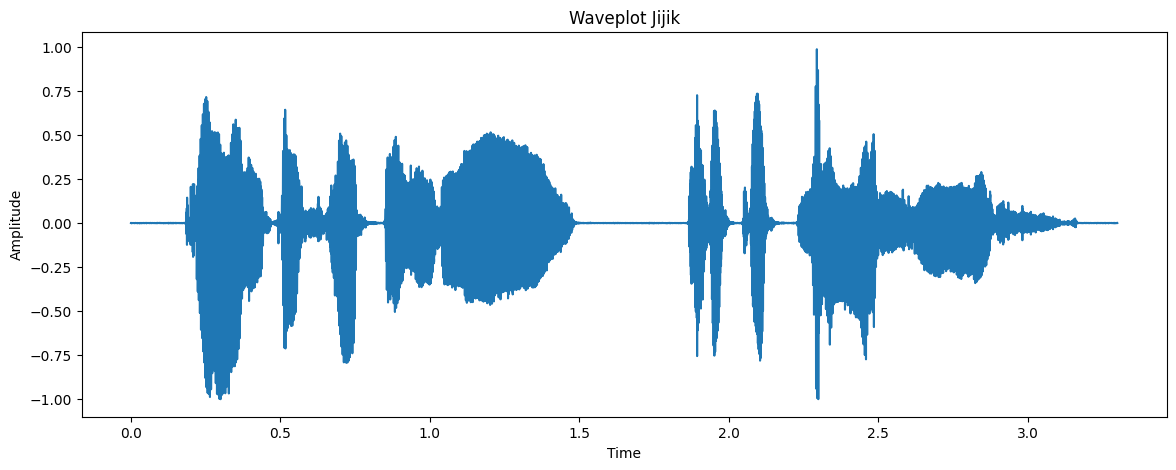

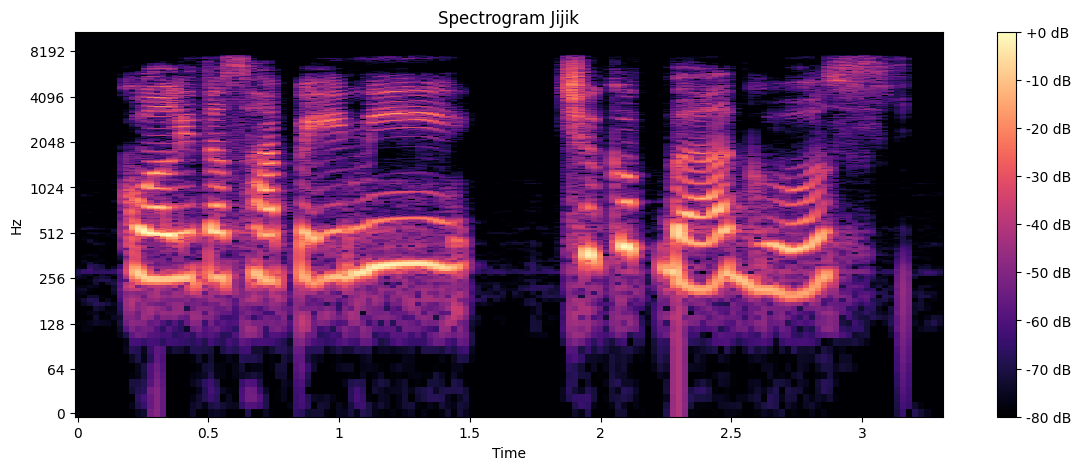

In [27]:
emotion = 'Jijik'
paths = np.array(df['path'][df['emosi'] == emotion])[35]

# Load the audio data and get the sampling rate
data, sampling_rate = librosa.load(paths)

# Waveplot
plt.figure(figsize=(14, 5))
plt.title('Waveplot Jijik')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(np.arange(len(data)) / sampling_rate, data)
plt.show()

# Spectrogram
plt.figure(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Jijik')
plt.show()
Audio(paths)

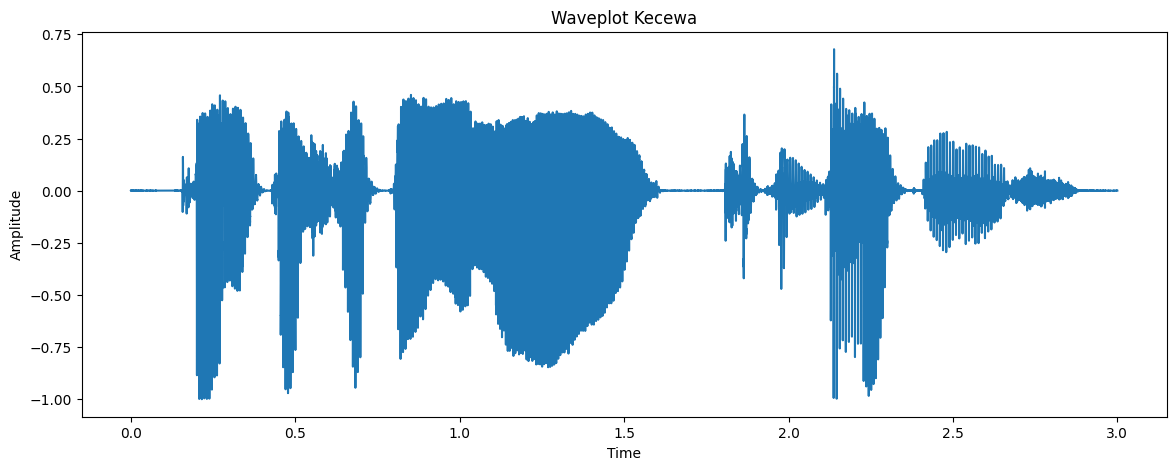

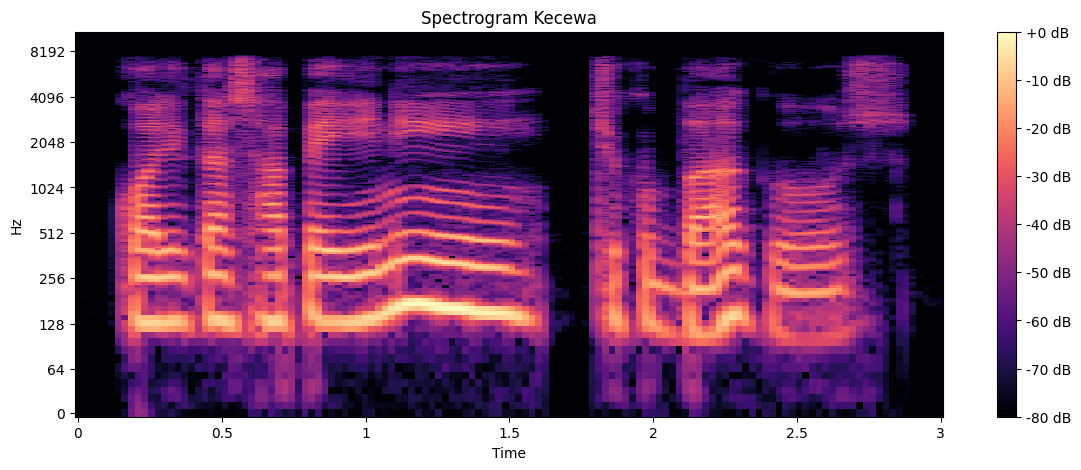

In [28]:
emotion = 'Kecewa'
paths = np.array(df['path'][df['emosi'] == emotion])[50]

# Load the audio data and get the sampling rate
data, sampling_rate = librosa.load(paths)

# Waveplot
plt.figure(figsize=(14, 5))
plt.title('Waveplot Kecewa')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(np.arange(len(data)) / sampling_rate, data)
plt.show()

# Spectrogram
plt.figure(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Kecewa')
plt.show()
Audio(paths)

## Feature Extraction

### MFCC

In [5]:
def extract_mfcc(filename, n_mfcc=40, duration=3, offset=0.5):
    y, sr = librosa.load(filename, duration=duration, offset=offset)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc.T, axis=0)
    return mfcc_mean

In [6]:
extract_mfcc(df['path'][0])

array([-310.3727   ,   89.42707  ,   -5.002537 ,   45.108185 ,
        -28.18145  ,    1.0313294,  -13.933303 ,   -6.250558 ,
        -18.80358  ,   -8.875765 ,   -7.8153534,  -10.976344 ,
         -1.8067925,  -14.960815 ,    2.9725113,  -13.208093 ,
         -8.190284 ,   -3.730549 ,   -9.972042 ,   -8.8986845,
         -7.6499486,   -6.9391184,   -9.34261  ,   -4.8171773,
         -8.12267  ,   -2.9732068,   -8.181031 ,   -3.566138 ,
         -4.520893 ,   -5.1939845,   -1.5096108,   -6.8051553,
         -1.948944 ,   -4.562287 ,   -2.7517035,   -3.6581802,
         -3.968044 ,   -4.641624 ,   -2.5658946,   -1.1098495],
      dtype=float32)

#### DataFrame

In [7]:
X_mfcc = df['path'].apply(lambda x: extract_mfcc(x))
mfcc = np.stack(X_mfcc.values)
X_mfcc

0      [-310.3727, 89.42707, -5.002537, 45.108185, -2...
1      [-293.58374, 96.594345, -6.6026344, 49.63558, ...
2      [-275.0798, 96.307755, -5.3895497, 52.651905, ...
3      [-300.9955, 86.69134, -4.7884502, 37.07431, -2...
4      [-296.57416, 97.53068, -4.8118505, 43.048214, ...
                             ...                        
295    [-322.98322, 84.86375, 4.3241076, 36.054813, -...
296    [-315.5319, 84.19446, 0.0055141924, 33.952553,...
297    [-342.7631, 94.137825, -1.906536, 30.528961, -...
298    [-367.06488, 98.17489, 11.441321, 34.113586, -...
299    [-342.96817, 88.019485, 0.50365645, 33.983727,...
Name: path, Length: 300, dtype: object

In [11]:
mfcc = [x for x in X_mfcc]
mfcc = np.array(mfcc)
mfcc.shape

(300, 40)

In [12]:
## input split
mfcc = np.expand_dims(mfcc, -1)
mfcc.shape

(300, 40, 1)

### Multispektrum Hilbert

In [8]:
def extract_hilbert_spectrum(filename, duration=3, offset=0.5, n_fft=2048):
    y, sr = librosa.load(filename, duration=duration, offset=offset)
    analytic_signal = hilbert(y)
    amplitude_envelope = np.abs(analytic_signal)
    # Ambil spektrum dari envelope
    spectrum = np.abs(np.fft.fft(amplitude_envelope, n=n_fft))[:n_fft // 2]
    # Normalisasi dan ambil beberapa fitur statistik
    spectrum = spectrum / np.max(spectrum)
    hilbert_features = [
        np.mean(spectrum),
        np.std(spectrum),
        np.max(spectrum),
        np.min(spectrum),
        np.median(spectrum)
    ]
    return np.array(hilbert_features)

In [11]:
extract_hilbert_spectrum(df['path'][0])

array([8.75233245e-03, 4.91285442e-02, 1.00000000e+00, 6.77558190e-05,
       1.14412157e-03])

#### DataFrame

In [9]:
X_hilbert_spectrum = df['path'].apply(lambda x: extract_hilbert_spectrum(x))
hilbert_spectrum = np.stack(X_hilbert_spectrum.values)
X_hilbert_spectrum

0      [0.008752332448797653, 0.04912854424736267, 1....
1      [0.005288961399542223, 0.03747307682447889, 1....
2      [0.005280706248361602, 0.03942615881364781, 1....
3      [0.002759409059973731, 0.03156630348123844, 1....
4      [0.020940048797470686, 0.07969693023494996, 1....
                             ...                        
295    [0.006688995444736086, 0.03590170748252481, 1....
296    [0.00810433468133241, 0.035891502728349615, 1....
297    [0.005389268370959109, 0.034582089975262964, 1...
298    [0.006951130649379238, 0.03536102001387962, 1....
299    [0.005075347482459223, 0.034451837088226966, 1...
Name: path, Length: 300, dtype: object

In [10]:
hilbert_spectrum = [x for x in X_hilbert_spectrum]
hilbert_spectrum = np.array(hilbert_spectrum)
hilbert_spectrum.shape

(300, 5)

In [13]:
## input split
hilbert_spectrum = np.expand_dims(hilbert_spectrum, -1)
hilbert_spectrum.shape

(300, 5, 1)

### Cochleagram

In [14]:
# Menggunakan mel-spectrogram sebagai pendekatan awal cochleagram
def extract_cochleagram(filename, duration=3, offset=0.5, n_mels=40):
    y, sr = librosa.load(filename, duration=duration, offset=offset)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    cochleagram = np.mean(S.T, axis=0)
    return cochleagram

In [42]:
extract_cochleagram(df['path'][0])

array([5.8757730e+00, 2.0322685e+01, 1.7643375e+01, 1.5564642e+01,
       1.9900406e+01, 1.6725960e+01, 2.3746872e+01, 5.8509374e+00,
       2.8892300e+00, 2.0680723e+00, 1.1467699e+00, 7.7132148e-01,
       2.9454777e-01, 4.0391651e-01, 3.4771484e-01, 2.8200710e-01,
       2.0092079e-01, 7.0594706e-02, 3.1501617e-02, 3.5627317e-02,
       3.6391895e-02, 4.7037598e-02, 9.7727217e-02, 1.3510297e-01,
       6.8537124e-02, 4.7395222e-02, 4.6983667e-02, 8.2774319e-02,
       9.9425733e-02, 4.5039557e-02, 2.0534910e-02, 4.1386660e-02,
       5.5500343e-02, 2.3037354e-02, 1.1253827e-02, 3.6242341e-03,
       1.1092415e-04, 9.5813864e-09, 1.0280217e-08, 7.4828836e-09],
      dtype=float32)

#### DataFrame

In [15]:
X_cochleagram = df['path'].apply(lambda x: extract_cochleagram(x))
cochleagram = np.stack(X_cochleagram.values)
X_cochleagram

0      [5.875773, 20.322685, 17.643375, 15.564642, 19...
1      [5.7660913, 17.519556, 27.385136, 17.222183, 2...
2      [7.1848683, 18.323599, 31.402145, 17.366495, 2...
3      [3.0101213, 19.60856, 18.508541, 24.28324, 40....
4      [3.6488898, 18.657244, 25.69851, 20.920523, 22...
                             ...                        
295    [0.1993098, 35.60238, 75.40692, 30.398325, 14....
296    [0.7443989, 33.713253, 80.13643, 29.713634, 16...
297    [0.029411582, 10.920766, 61.428486, 47.109074,...
298    [0.025985274, 10.0745325, 47.83812, 29.173712,...
299    [0.016594524, 14.182042, 64.34807, 41.153362, ...
Name: path, Length: 300, dtype: object

In [16]:
cochleagram = [x for x in X_cochleagram]
cochleagram = np.array(cochleagram)
cochleagram.shape

(300, 40)

In [17]:
## input split
cochleagram = np.expand_dims(cochleagram, -1)
cochleagram.shape

(300, 40, 1)

### Menggabungkan semua fitur

In [18]:
def extract_hybrid_features(filename):
    mfcc = extract_mfcc(filename)
    hilbert = extract_hilbert_spectrum(filename)
    cochleagram = extract_cochleagram(filename)
    return np.concatenate([mfcc, hilbert, cochleagram])

In [20]:
extract_hybrid_features(df['path'][0])

array([-3.10372711e+02,  8.94270706e+01, -5.00253677e+00,  4.51081848e+01,
       -2.81814499e+01,  1.03132939e+00, -1.39333029e+01, -6.25055790e+00,
       -1.88035793e+01, -8.87576485e+00, -7.81535339e+00, -1.09763441e+01,
       -1.80679250e+00, -1.49608154e+01,  2.97251129e+00, -1.32080927e+01,
       -8.19028378e+00, -3.73054910e+00, -9.97204208e+00, -8.89868450e+00,
       -7.64994860e+00, -6.93911839e+00, -9.34261036e+00, -4.81717730e+00,
       -8.12267017e+00, -2.97320676e+00, -8.18103123e+00, -3.56613803e+00,
       -4.52089310e+00, -5.19398451e+00, -1.50961077e+00, -6.80515528e+00,
       -1.94894397e+00, -4.56228685e+00, -2.75170350e+00, -3.65818024e+00,
       -3.96804404e+00, -4.64162397e+00, -2.56589460e+00, -1.10984945e+00,
        8.75233245e-03,  4.91285442e-02,  1.00000000e+00,  6.77558190e-05,
        1.14412157e-03,  5.87577295e+00,  2.03226852e+01,  1.76433754e+01,
        1.55646420e+01,  1.99004059e+01,  1.67259598e+01,  2.37468719e+01,
        5.85093737e+00,  

#### DataFrame

In [19]:
X_hybrid = df['path'].apply(lambda x: extract_hybrid_features(x))
hybrid = np.stack(X_hybrid.values)
print(hybrid.shape)

(300, 85)


In [20]:
hybrid = np.expand_dims(hybrid, -1)
print(hybrid.shape)

(300, 85, 1)


## Encoding Label Emosi

In [21]:
enc = OneHotEncoder()
y = enc.fit_transform(df[['emosi']])

In [22]:
y = y.toarray()
y.shape

(300, 5)

In [23]:
print(mfcc.shape)         # (n_samples, 1, 40)
print(hilbert_spectrum.shape)      # (n_samples, 1, 15)
print(cochleagram.shape)  # (n_samples, 64, 192, 1)
print(y.shape)              # (n_samples, n_classes)

(300, 40, 1)
(300, 5, 1)
(300, 40, 1)
(300, 5)


In [24]:
scaler = MinMaxScaler()
hybrid_scaled = scaler.fit_transform(hybrid.reshape(hybrid.shape[0], -1))
hybrid_scaled

array([[5.75115261e-01, 4.65159234e-01, 6.94483927e-01, ...,
        3.43298481e-05, 3.67670635e-05, 2.39263547e-05],
       [6.70633114e-01, 5.62009571e-01, 6.70763534e-01, ...,
        7.56661832e-05, 9.01428898e-05, 1.00432767e-04],
       [7.75907960e-01, 5.58136914e-01, 6.88746715e-01, ...,
        5.44158971e-05, 7.42601326e-05, 7.58526587e-05],
       ...,
       [3.90835970e-01, 5.28814973e-01, 7.40380098e-01, ...,
        4.49647597e-03, 3.01457693e-03, 2.89506422e-03],
       [2.52575283e-01, 5.83367226e-01, 9.38253285e-01, ...,
        3.25018214e-03, 2.20777345e-03, 2.26396619e-03],
       [3.89669214e-01, 4.46138740e-01, 7.76109612e-01, ...,
        1.06542069e-04, 1.03991057e-04, 9.10133266e-05]])

In [25]:
hybrid_scaled = np.expand_dims(hybrid_scaled, axis=-1)
hybrid_scaled

array([[[5.75115261e-01],
        [4.65159234e-01],
        [6.94483927e-01],
        ...,
        [3.43298481e-05],
        [3.67670635e-05],
        [2.39263547e-05]],

       [[6.70633114e-01],
        [5.62009571e-01],
        [6.70763534e-01],
        ...,
        [7.56661832e-05],
        [9.01428898e-05],
        [1.00432767e-04]],

       [[7.75907960e-01],
        [5.58136914e-01],
        [6.88746715e-01],
        ...,
        [5.44158971e-05],
        [7.42601326e-05],
        [7.58526587e-05]],

       ...,

       [[3.90835970e-01],
        [5.28814973e-01],
        [7.40380098e-01],
        ...,
        [4.49647597e-03],
        [3.01457693e-03],
        [2.89506422e-03]],

       [[2.52575283e-01],
        [5.83367226e-01],
        [9.38253285e-01],
        ...,
        [3.25018214e-03],
        [2.20777345e-03],
        [2.26396619e-03]],

       [[3.89669214e-01],
        [4.46138740e-01],
        [7.76109612e-01],
        ...,
        [1.06542069e-04],
        [1.0399

In [26]:
hybrid_scaled.shape

(300, 85, 1)

In [27]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(hybrid_scaled, y, test_size=0.2, random_state=42, stratify=y)

## Model CNN

In [41]:
input_shape = (hybrid_scaled.shape[1], 1)  # (85, 1) jika fitur hybrid berjumlah 85

model_cnn = Sequential([
    Conv1D(256, kernel_size=5, activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 kelas emosi
])

model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 81, 256)           1536      
                                                                 
 batch_normalization_2 (Bat  (None, 81, 256)           1024      
 chNormalization)                                                
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 40, 256)           0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 40, 256)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 38, 128)           98432     
                                                                 
 batch_normalization_3 (Bat  (None, 38, 128)          

In [42]:
history_cnn = model_cnn.fit(hybrid_scaled, y, validation_split=0.2, epochs=50, batch_size=32)

Epoch 1/50
8/8 [==============================] - 8s 426ms/step - loss: 2.3558 - accuracy: 0.3000 - val_loss: 1.5997 - val_accuracy: 0.2000
Epoch 2/50
8/8 [==============================] - 1s 180ms/step - loss: 1.3420 - accuracy: 0.4167 - val_loss: 1.5972 - val_accuracy: 0.3167
Epoch 3/50
8/8 [==============================] - 1s 180ms/step - loss: 1.1900 - accuracy: 0.4792 - val_loss: 1.5919 - val_accuracy: 0.2500
Epoch 4/50
8/8 [==============================] - 1s 171ms/step - loss: 1.0287 - accuracy: 0.5667 - val_loss: 1.5903 - val_accuracy: 0.2667
Epoch 5/50
8/8 [==============================] - 1s 171ms/step - loss: 1.1245 - accuracy: 0.5208 - val_loss: 1.5960 - val_accuracy: 0.2000
Epoch 6/50
8/8 [==============================] - 1s 176ms/step - loss: 0.9579 - accuracy: 0.6208 - val_loss: 1.5993 - val_accuracy: 0.2000
Epoch 7/50
8/8 [==============================] - 1s 171ms/step - loss: 0.9486 - accuracy: 0.6000 - val_loss: 1.6151 - val_accuracy: 0.2000
Epoch 8/50
8/8 [====

In [43]:
history_cnn_split = model_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

Epoch 1/50
8/8 [==============================] - 3s 338ms/step - loss: 0.8674 - accuracy: 0.8250 - val_loss: 1.7279 - val_accuracy: 0.5000
Epoch 2/50
8/8 [==============================] - 2s 310ms/step - loss: 0.3672 - accuracy: 0.8917 - val_loss: 1.8158 - val_accuracy: 0.4667
Epoch 3/50
8/8 [==============================] - 2s 310ms/step - loss: 0.2846 - accuracy: 0.8875 - val_loss: 1.7775 - val_accuracy: 0.4667
Epoch 4/50
8/8 [==============================] - 3s 371ms/step - loss: 0.1628 - accuracy: 0.9417 - val_loss: 1.8421 - val_accuracy: 0.4500
Epoch 5/50
8/8 [==============================] - 3s 335ms/step - loss: 0.1678 - accuracy: 0.9458 - val_loss: 1.5884 - val_accuracy: 0.5000
Epoch 6/50
8/8 [==============================] - 3s 338ms/step - loss: 0.1437 - accuracy: 0.9500 - val_loss: 1.4602 - val_accuracy: 0.5333
Epoch 7/50
8/8 [==============================] - 3s 368ms/step - loss: 0.1173 - accuracy: 0.9583 - val_loss: 1.5787 - val_accuracy: 0.5167
Epoch 8/50
8/8 [====

In [ ]:
# Simpan model yang telah dilatih
model_cnn.save('dataset/modelPendekatan_CNN.h5')

# Simpan label encoder ke file
## np.save('Dataset/label_encoder.npy', label_encoder.classes_)
## np.save('dataset/label_encoder_CNN.npy', enc.categories_[0])

## Kurva Loss dan Akurasi CNN

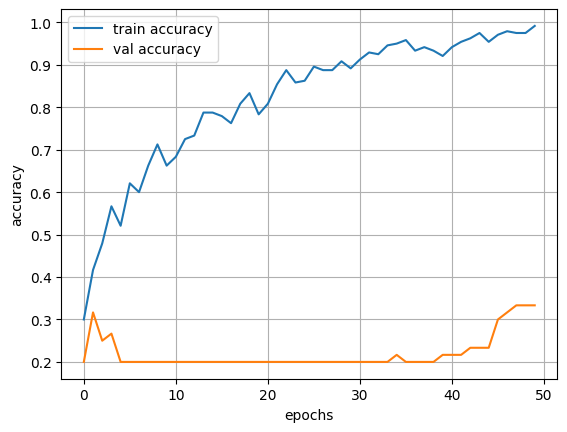

In [44]:
epochs = list(range(len(history_cnn.history['accuracy'])))
plt.plot(epochs, history_cnn.history['accuracy'], label='train accuracy')
plt.plot(epochs, history_cnn.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)
plt.show()

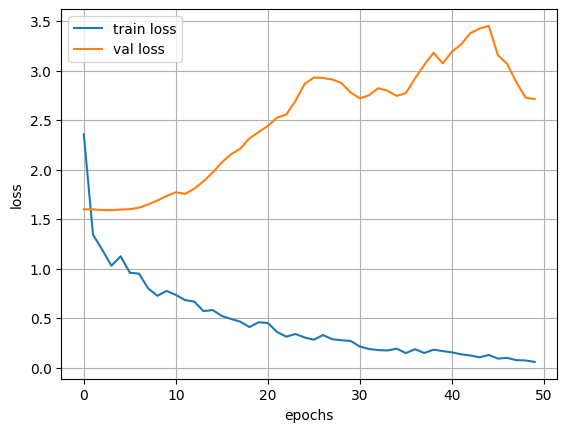

In [45]:
plt.plot(epochs, history_cnn.history['loss'], label='train loss')
plt.plot(epochs, history_cnn.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()

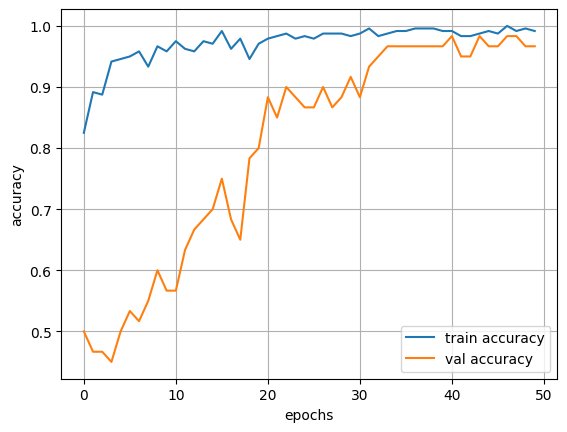

In [46]:
epochs = list(range(len(history_cnn_split.history['accuracy'])))
plt.plot(epochs, history_cnn_split.history['accuracy'], label='train accuracy')
plt.plot(epochs, history_cnn_split.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)
plt.show()

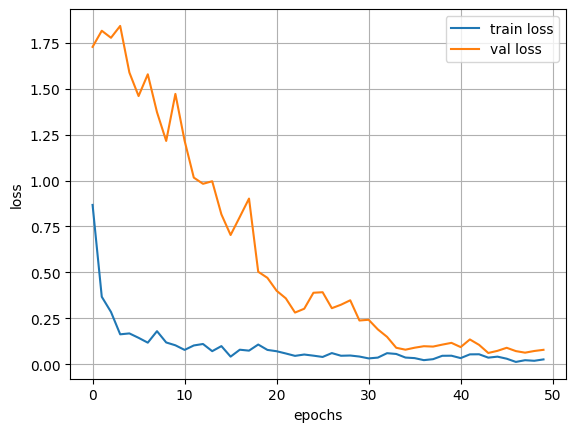

In [47]:
plt.plot(epochs, history_cnn_split.history['loss'], label='train loss')
plt.plot(epochs, history_cnn_split.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()

## Evaluasi CNN

In [48]:
# Prediksi
y_pred_proba_cnn = model_cnn.predict(X_test)
y_pred_cnn = np.argmax(y_pred_proba_cnn, axis=1)
y_true_cnn = np.argmax(y_test, axis=1)

2/2 [==============================] - 1s 65ms/step


### Confusion Matrix CNN

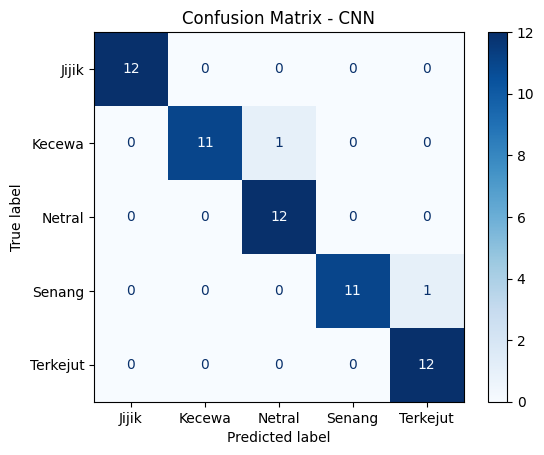

In [49]:
labels = enc.categories_[0]
cm = confusion_matrix(y_true_cnn, y_pred_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - CNN')
plt.show()

### Akurasi, Precision, Recall, F1-score (Metrics CNN)

In [50]:
print("Akurasi CNN:", accuracy_score(y_true_cnn, y_pred_cnn))
print("Precision (macro):", precision_score(y_true_cnn, y_pred_cnn, average='macro'))
print("Recall (macro):", recall_score(y_true_cnn, y_pred_cnn, average='macro'))
print("F1-score (macro):", f1_score(y_true_cnn, y_pred_cnn, average='macro'))
print("\nClassification Report:\n", classification_report(y_true_cnn, y_pred_cnn, target_names=labels))

Akurasi CNN: 0.9666666666666667
Precision (macro): 0.9692307692307693
Recall (macro): 0.9666666666666666
F1-score (macro): 0.966608695652174

Classification Report:
               precision    recall  f1-score   support

       Jijik       1.00      1.00      1.00        12
      Kecewa       1.00      0.92      0.96        12
      Netral       0.92      1.00      0.96        12
      Senang       1.00      0.92      0.96        12
    Terkejut       0.92      1.00      0.96        12

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



### AUC-ROC CNN

In [51]:
auc_roc_cnn = roc_auc_score(y_test, y_pred_proba_cnn, average='macro', multi_class='ovr')
print("AUC-ROC (macro, ovr) CNN:", auc_roc_cnn)

AUC-ROC (macro, ovr) CNN: 0.9996527777777778


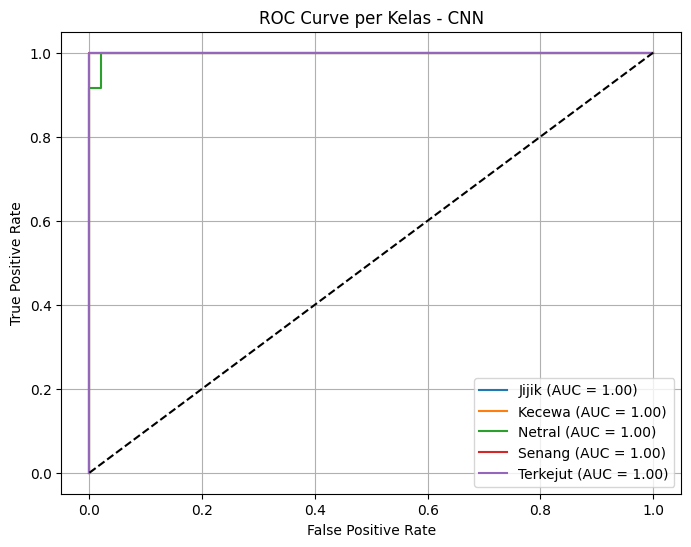

In [52]:
# ROC Curve per kelas
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba_cnn[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Kelas - CNN')
plt.legend()
plt.grid(True)
plt.show()

## Model LSTM

In [ ]:
input_shape = (hybrid_scaled.shape[1], 1)

model_lstm = Sequential([
    LSTM(128, return_sequences=True, activation='tanh', input_shape=input_shape),
    BatchNormalization(),
    Dropout(0.25),
    LSTM(64, return_sequences=False, activation='tanh'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 85, 256)           264192    
                                                                 
 batch_normalization_53 (Ba  (None, 85, 256)           1024      
 tchNormalization)                                               
                                                                 
 dropout_59 (Dropout)        (None, 85, 256)           0         
                                                                 
 lstm_27 (LSTM)              (None, 128)               197120    
                                                                 
 batch_normalization_54 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_60 (Dropout)        (None, 128)             

In [131]:
# Training
history_lstm = model_lstm.fit(hybrid_scaled, y, validation_split=0.2, epochs=50, batch_size=32)

Epoch 1/50
8/8 [==============================] - 53s 4s/step - loss: 2.1525 - accuracy: 0.1708 - val_loss: 1.6076 - val_accuracy: 0.2000
Epoch 2/50
8/8 [==============================] - 24s 3s/step - loss: 1.8259 - accuracy: 0.2125 - val_loss: 1.5994 - val_accuracy: 0.2000
Epoch 3/50
8/8 [==============================] - 26s 3s/step - loss: 1.7786 - accuracy: 0.2792 - val_loss: 1.5990 - val_accuracy: 0.2000
Epoch 4/50
8/8 [==============================] - 27s 3s/step - loss: 1.5877 - accuracy: 0.3250 - val_loss: 1.6039 - val_accuracy: 0.2000
Epoch 5/50
8/8 [==============================] - 28s 3s/step - loss: 1.6719 - accuracy: 0.3375 - val_loss: 1.6052 - val_accuracy: 0.2000
Epoch 6/50
8/8 [==============================] - 29s 4s/step - loss: 1.5188 - accuracy: 0.3833 - val_loss: 1.6193 - val_accuracy: 0.2000
Epoch 7/50
8/8 [==============================] - 27s 3s/step - loss: 1.6685 - accuracy: 0.3042 - val_loss: 1.6160 - val_accuracy: 0.2000
Epoch 8/50
8/8 [==================

In [132]:
history_lstm_split = model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

Epoch 1/50
8/8 [==============================] - 26s 3s/step - loss: 1.7139 - accuracy: 0.1792 - val_loss: 4.2015 - val_accuracy: 0.2000
Epoch 2/50
8/8 [==============================] - 26s 3s/step - loss: 1.6513 - accuracy: 0.2167 - val_loss: 4.9191 - val_accuracy: 0.2000
Epoch 3/50
8/8 [==============================] - 25s 3s/step - loss: 1.7059 - accuracy: 0.2167 - val_loss: 5.8907 - val_accuracy: 0.2000
Epoch 4/50
8/8 [==============================] - 26s 3s/step - loss: 1.6367 - accuracy: 0.2542 - val_loss: 5.6277 - val_accuracy: 0.2000
Epoch 5/50
8/8 [==============================] - 26s 3s/step - loss: 1.6083 - accuracy: 0.2583 - val_loss: 5.4345 - val_accuracy: 0.2000
Epoch 6/50
8/8 [==============================] - 26s 3s/step - loss: 1.6686 - accuracy: 0.2167 - val_loss: 4.3182 - val_accuracy: 0.2000
Epoch 7/50
8/8 [==============================] - 27s 3s/step - loss: 1.6737 - accuracy: 0.2292 - val_loss: 2.8587 - val_accuracy: 0.2000
Epoch 8/50
8/8 [==================

In [ ]:
# Simpan model yang telah dilatih
model_lstm.save('dataset/modelPendekatan_LSTM.h5')

# Simpan label encoder ke file
## np.save('Dataset/label_encoder.npy', label_encoder.classes_)
# np.save('dataset/label_encoder_LSTM.npy', enc.categories_[0])

## Kurva Loss dan Akurasi LSTM

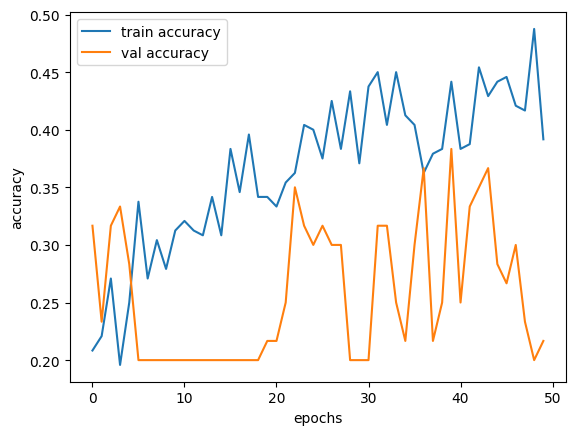

In [56]:
epochs = list(range(len(history_lstm.history['accuracy'])))
plt.plot(epochs, history_lstm.history['accuracy'], label='train accuracy')
plt.plot(epochs, history_lstm.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

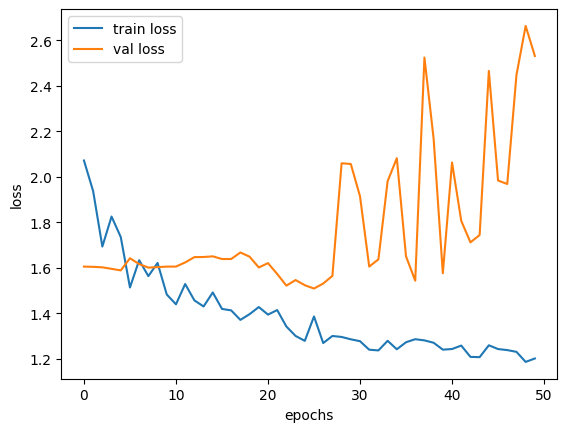

In [57]:
plt.plot(epochs, history_lstm.history['loss'], label='train loss')
plt.plot(epochs, history_lstm.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

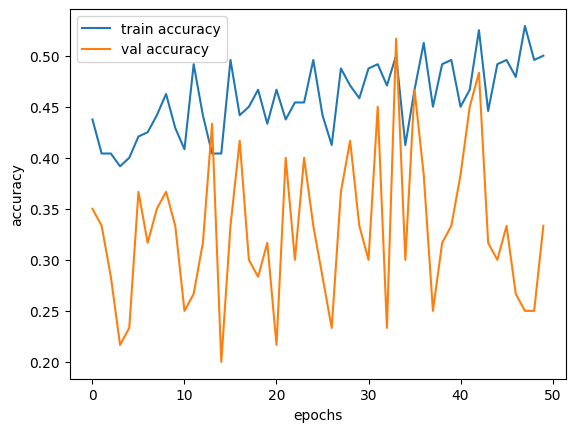

In [58]:
epochs = list(range(len(history_lstm_split.history['accuracy'])))
plt.plot(epochs, history_lstm_split.history['accuracy'], label='train accuracy')
plt.plot(epochs, history_lstm_split.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

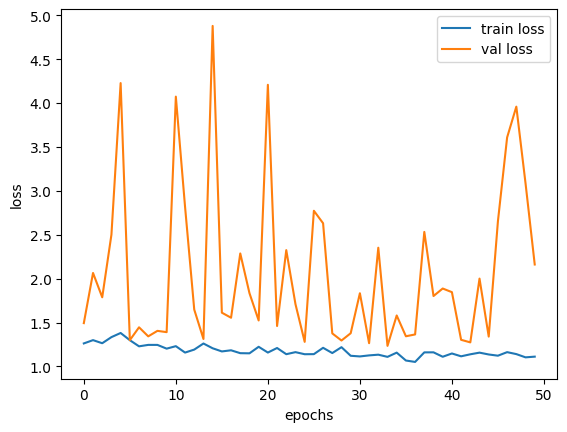

In [59]:
plt.plot(epochs, history_lstm_split.history['loss'], label='train loss')
plt.plot(epochs, history_lstm_split.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Evaluasi LSTM

In [60]:
# Prediksi
y_pred_proba_lstm = model_lstm.predict(X_test)
y_pred_lstm = np.argmax(y_pred_proba_lstm, axis=1)
y_true_lstm = np.argmax(y_test, axis=1)

2/2 [==============================] - 3s 132ms/step


### Confusion Matrix

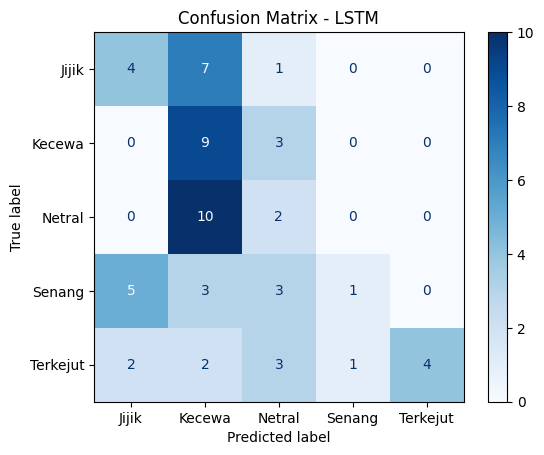

In [61]:
labels = enc.categories_[0]
cm = confusion_matrix(y_true_lstm, y_pred_lstm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - LSTM')
plt.show()

### Akurasi, Precision, Recall, F1-score (Metrics LSTM)

In [62]:
print("Akurasi LSTM:", accuracy_score(y_true_lstm, y_pred_lstm))
print("Precision (macro):", precision_score(y_true_lstm, y_pred_lstm, average='macro'))
print("Recall (macro):", recall_score(y_true_lstm, y_pred_lstm, average='macro'))
print("F1-score (macro):", f1_score(y_true_lstm, y_pred_lstm, average='macro'))
print("\nClassification Report:\n", classification_report(y_true_lstm, y_pred_lstm, target_names=labels))

Akurasi LSTM: 0.3333333333333333
Precision (macro): 0.46412512218963836
Recall (macro): 0.3333333333333333
F1-score (macro): 0.3151909095286244

Classification Report:
               precision    recall  f1-score   support

       Jijik       0.36      0.33      0.35        12
      Kecewa       0.29      0.75      0.42        12
      Netral       0.17      0.17      0.17        12
      Senang       0.50      0.08      0.14        12
    Terkejut       1.00      0.33      0.50        12

    accuracy                           0.33        60
   macro avg       0.46      0.33      0.32        60
weighted avg       0.46      0.33      0.32        60



### AUC-ROC LSTM

In [63]:
auc_roc_lstm = roc_auc_score(y_test, y_pred_proba_lstm, average='macro', multi_class='ovr')
print("AUC-ROC (macro, ovr) LSTM:", auc_roc_lstm)

AUC-ROC (macro, ovr) LSTM: 0.6913194444444444


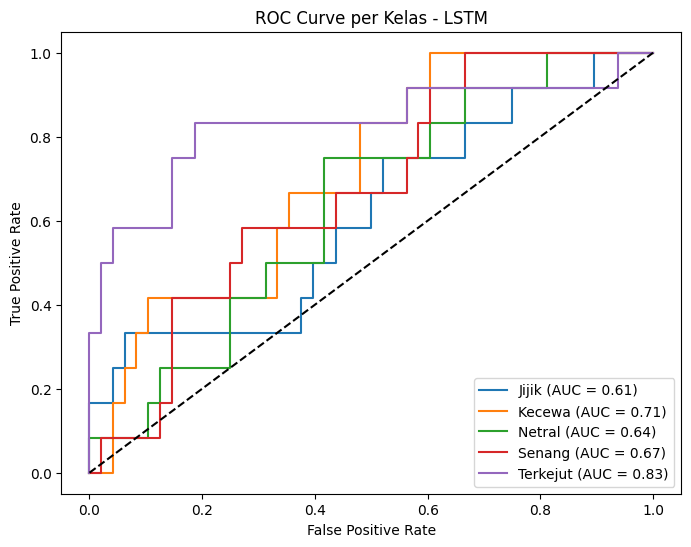

In [64]:
# ROC Curve per kelas
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba_lstm[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Kelas - LSTM')
plt.legend()
plt.show()

## Model CNN + LSTM

In [106]:
input_shape = (hybrid_scaled.shape[1], 1)

model_hybrid = Sequential([
    Conv1D(256, kernel_size=5, activation='relu', padding='same', kernel_initializer='he_normal', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(128, return_sequences=True, activation='tanh'),
    BatchNormalization(),
    Dropout(0.25),
    LSTM(64, return_sequences=False, activation='tanh'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(128, activation='relu'),   
    BatchNormalization(),              
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 kelas emosi
])

model_hybrid.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_hybrid.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_22 (Conv1D)          (None, 85, 256)           1536      
                                                                 
 batch_normalization_42 (Ba  (None, 85, 256)           1024      
 tchNormalization)                                               
                                                                 
 max_pooling1d_22 (MaxPooli  (None, 42, 256)           0         
 ng1D)                                                           
                                                                 
 dropout_45 (Dropout)        (None, 42, 256)           0         
                                                                 
 conv1d_23 (Conv1D)          (None, 40, 128)           98432     
                                                                 
 batch_normalization_43 (Ba  (None, 40, 128)         

In [107]:
history_hybrid = model_hybrid.fit(hybrid_scaled, y, validation_split=0.2, epochs=50, batch_size=32)

Epoch 1/50
8/8 [==============================] - 47s 3s/step - loss: 2.2026 - accuracy: 0.2500 - val_loss: 1.6011 - val_accuracy: 0.2833
Epoch 2/50
8/8 [==============================] - 5s 575ms/step - loss: 2.0438 - accuracy: 0.2250 - val_loss: 1.5955 - val_accuracy: 0.2000
Epoch 3/50
8/8 [==============================] - 5s 580ms/step - loss: 1.9259 - accuracy: 0.2625 - val_loss: 1.5788 - val_accuracy: 0.2000
Epoch 4/50
8/8 [==============================] - 5s 598ms/step - loss: 1.9071 - accuracy: 0.2542 - val_loss: 1.5628 - val_accuracy: 0.2000
Epoch 5/50
8/8 [==============================] - 5s 595ms/step - loss: 1.7585 - accuracy: 0.3000 - val_loss: 1.5547 - val_accuracy: 0.2333
Epoch 6/50
8/8 [==============================] - 5s 574ms/step - loss: 1.6655 - accuracy: 0.3375 - val_loss: 1.5573 - val_accuracy: 0.2333
Epoch 7/50
8/8 [==============================] - 5s 574ms/step - loss: 1.6028 - accuracy: 0.3417 - val_loss: 1.5633 - val_accuracy: 0.2333
Epoch 8/50
8/8 [======

In [108]:
history_hybrid_split = model_hybrid.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

Epoch 1/50
8/8 [==============================] - 4s 540ms/step - loss: 0.8833 - accuracy: 0.7125 - val_loss: 1.4376 - val_accuracy: 0.5667
Epoch 2/50
8/8 [==============================] - 4s 507ms/step - loss: 0.7462 - accuracy: 0.7250 - val_loss: 1.1118 - val_accuracy: 0.6167
Epoch 3/50
8/8 [==============================] - 4s 513ms/step - loss: 0.8800 - accuracy: 0.6750 - val_loss: 0.8836 - val_accuracy: 0.7000
Epoch 4/50
8/8 [==============================] - 4s 509ms/step - loss: 0.7708 - accuracy: 0.7000 - val_loss: 0.9089 - val_accuracy: 0.7000
Epoch 5/50
8/8 [==============================] - 4s 511ms/step - loss: 0.7313 - accuracy: 0.7208 - val_loss: 0.8374 - val_accuracy: 0.7500
Epoch 6/50
8/8 [==============================] - 4s 515ms/step - loss: 0.6912 - accuracy: 0.7708 - val_loss: 0.7374 - val_accuracy: 0.7500
Epoch 7/50
8/8 [==============================] - 4s 503ms/step - loss: 0.5679 - accuracy: 0.7750 - val_loss: 0.8072 - val_accuracy: 0.7167
Epoch 8/50
8/8 [====

In [ ]:
# Simpan model yang telah dilatih
model_hybrid.save('dataset/modelPendekatan_hybrid.h5')

# Simpan label encoder ke file
## np.save('Dataset/label_encoder.npy', label_encoder.classes_)
## np.save('dataset/label_encoder_hybrid.npy', enc.categories_[0])

## Kurva Loss dan Akurasi

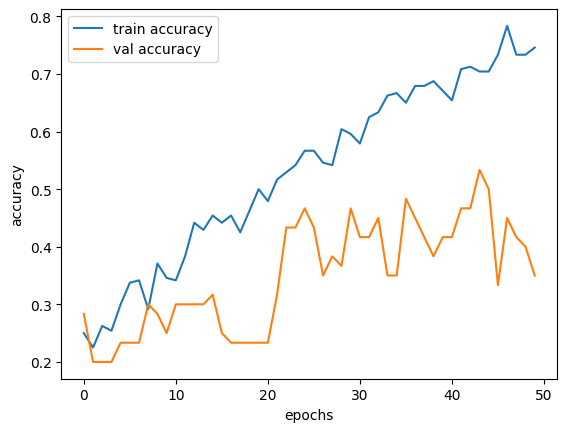

In [109]:
epochs = list(range(len(history_hybrid.history['accuracy'])))
plt.plot(epochs, history_hybrid.history['accuracy'], label='train accuracy')
plt.plot(epochs, history_hybrid.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

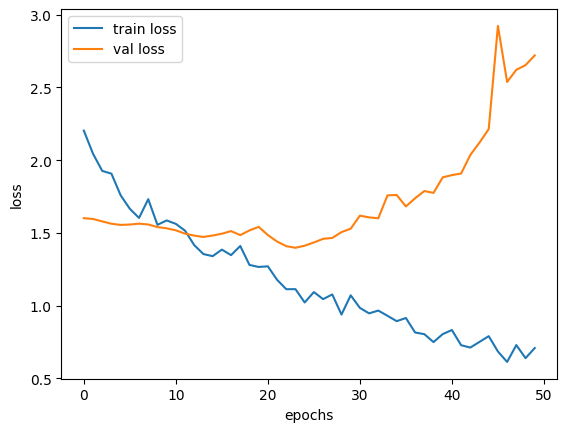

In [110]:
plt.plot(epochs, history_hybrid.history['loss'], label='train loss')
plt.plot(epochs, history_hybrid.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

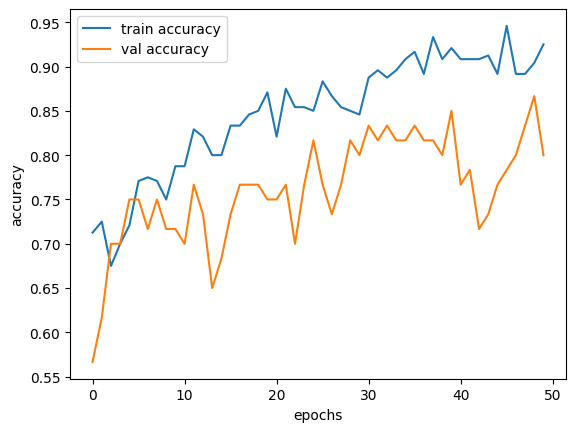

In [111]:
epochs = list(range(len(history_hybrid_split.history['accuracy'])))
plt.plot(epochs, history_hybrid_split.history['accuracy'], label='train accuracy')
plt.plot(epochs, history_hybrid_split.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

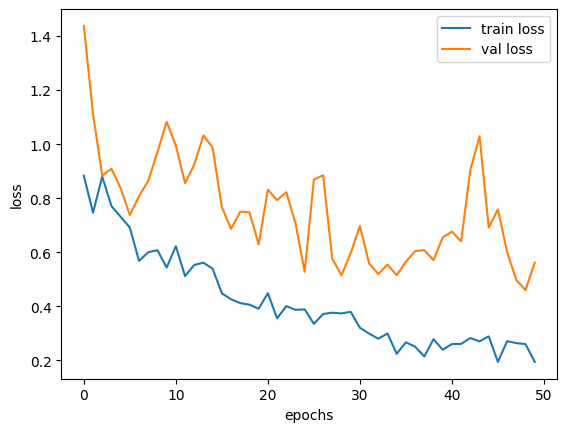

In [112]:
plt.plot(epochs, history_hybrid_split.history['loss'], label='train loss')
plt.plot(epochs, history_hybrid_split.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Evaluasi

In [113]:
# Prediksi probabilitas
y_pred_proba_hybrid = model_hybrid.predict(X_test)
# Prediksi kelas
y_pred_hybrid = np.argmax(y_pred_proba_hybrid, axis=1)
y_true_hybrid = np.argmax(y_test, axis=1)

2/2 [==============================] - 3s 110ms/step


### Confusion Matrix

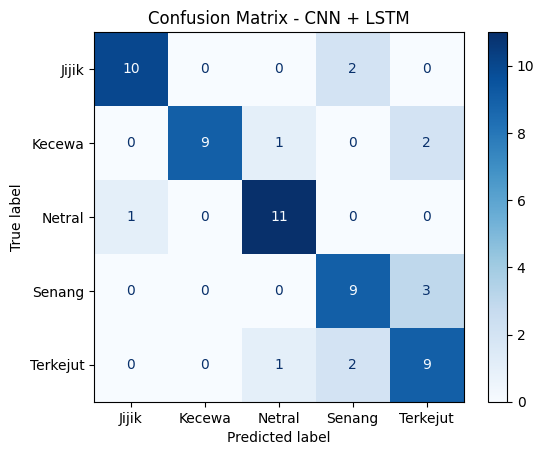

In [114]:
labels = enc.categories_[0]  # Label emosi IndoWaveSentiment
cm = confusion_matrix(y_true_hybrid, y_pred_hybrid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - CNN + LSTM')
plt.show()

### Akurasi, Precision, Recall, F1-score (Metrics)

In [115]:

print("Akurasi:", accuracy_score(y_true_hybrid, y_pred_hybrid))
print("Precision (macro):", precision_score(y_true_hybrid, y_pred_hybrid, average='macro'))
print("Recall (macro):", recall_score(y_true_hybrid, y_pred_hybrid, average='macro'))
print("F1-score (macro):", f1_score(y_true_hybrid, y_pred_hybrid, average='macro'))
print("\nClassification Report:\n", classification_report(y_true_hybrid, y_pred_hybrid, target_names=labels))

Akurasi: 0.8
Precision (macro): 0.8180819180819181
Recall (macro): 0.8
F1-score (macro): 0.8038031533683707

Classification Report:
               precision    recall  f1-score   support

       Jijik       0.91      0.83      0.87        12
      Kecewa       1.00      0.75      0.86        12
      Netral       0.85      0.92      0.88        12
      Senang       0.69      0.75      0.72        12
    Terkejut       0.64      0.75      0.69        12

    accuracy                           0.80        60
   macro avg       0.82      0.80      0.80        60
weighted avg       0.82      0.80      0.80        60



### AUC-ROC

In [116]:
from sklearn.metrics import roc_auc_score
# Untuk multi-class, gunakan average='macro' dan input probabilitas
auc_roc = roc_auc_score(y_test, y_pred_proba_hybrid, average='macro', multi_class='ovr')
print("AUC-ROC (macro, ovr):", auc_roc)

AUC-ROC (macro, ovr): 0.9715277777777777


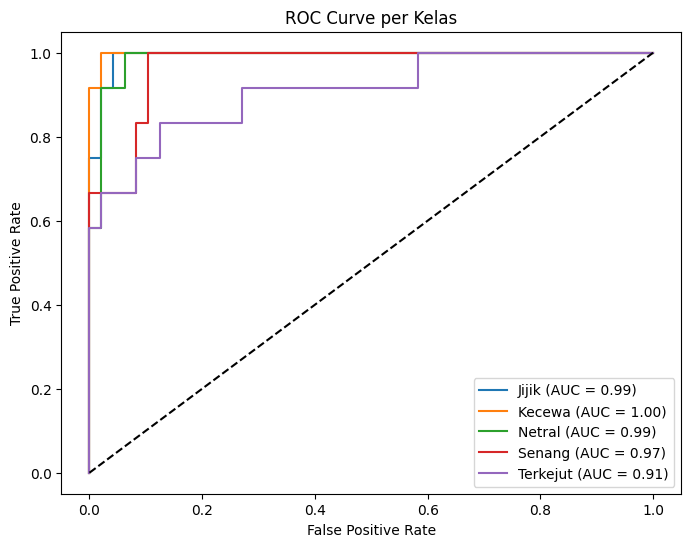

In [117]:

plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba_hybrid[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Kelas')
plt.legend()
plt.show()

# Perbandingan Kinerja antar Model

In [119]:
# Kumpulkan semua metrik ke dalam dictionary
metrics_data = {
    'Model': ['CNN', 'LSTM', 'Hybrid (CNN+LSTM)'],
    'Akurasi': [
        accuracy_score(y_true_cnn, y_pred_cnn),
        accuracy_score(y_true_lstm, y_pred_lstm),
        accuracy_score(y_true_hybrid, y_pred_hybrid)
    ],
    'Precision (macro)': [
        precision_score(y_true_cnn, y_pred_cnn, average='macro'),
        precision_score(y_true_lstm, y_pred_lstm, average='macro'),
        precision_score(y_true_hybrid, y_pred_hybrid, average='macro')
    ],
    'Recall (macro)': [
        recall_score(y_true_cnn, y_pred_cnn, average='macro'),
        recall_score(y_true_lstm, y_pred_lstm, average='macro'),
        recall_score(y_true_hybrid, y_pred_hybrid, average='macro')
    ],
    'F1-score (macro)': [
        f1_score(y_true_cnn, y_pred_cnn, average='macro'),
        f1_score(y_true_lstm, y_pred_lstm, average='macro'),
        f1_score(y_true_hybrid, y_pred_hybrid, average='macro')
    ],
    'AUC-ROC (macro)': [
        roc_auc_score(y_test, y_pred_proba_cnn, average='macro', multi_class='ovr'),
        roc_auc_score(y_test, y_pred_proba_lstm, average='macro', multi_class='ovr'),
        roc_auc_score(y_test, y_pred_proba_hybrid, average='macro', multi_class='ovr')
    ]
}

# Buat DataFrame
comparison_df = pd.DataFrame(metrics_data)
print("Tabel Perbandingan Kinerja Model:")
print(comparison_df.to_string())

Tabel Perbandingan Kinerja Model:
               Model   Akurasi  Precision (macro)  Recall (macro)  F1-score (macro)  AUC-ROC (macro)
0                CNN  0.966667           0.969231        0.966667          0.966609         0.999653
1               LSTM  0.333333           0.464125        0.333333          0.315191         0.691319
2  Hybrid (CNN+LSTM)  0.800000           0.818082        0.800000          0.803803         0.971528


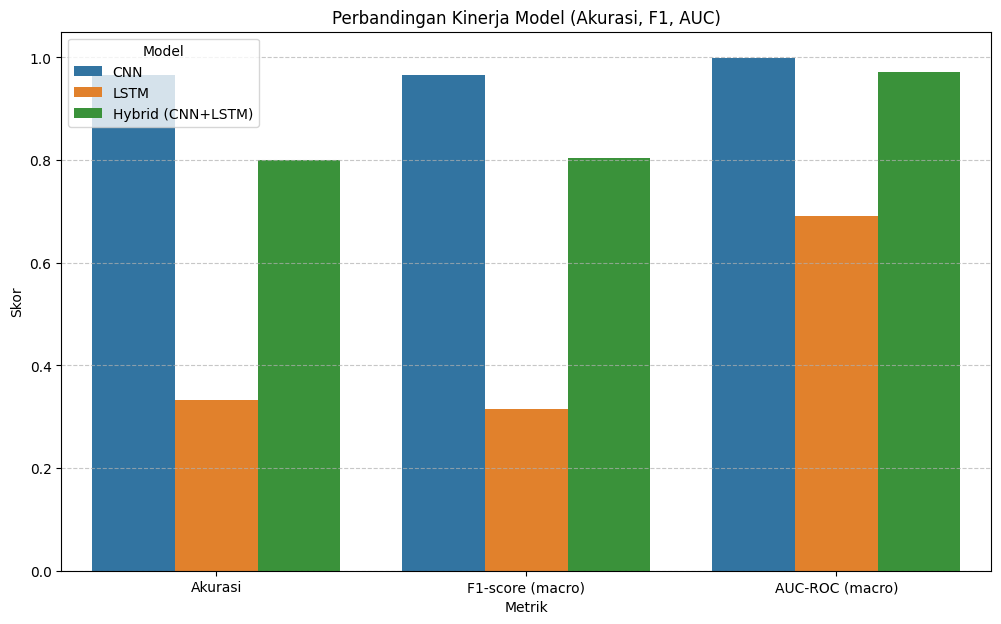

In [120]:
# Siapkan data untuk plot
plot_df = comparison_df.melt(id_vars='Model', value_vars=['Akurasi', 'F1-score (macro)', 'AUC-ROC (macro)'],
                             var_name='Metrik', value_name='Skor')

# Buat bar plot
plt.figure(figsize=(12, 7))
sns.barplot(data=plot_df, x='Metrik', y='Skor', hue='Model')
plt.title('Perbandingan Kinerja Model (Akurasi, F1, AUC)')
plt.ylabel('Skor')
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [122]:
# Siapkan probabilitas dari setiap model
models_proba = {
    'CNN': y_pred_proba_cnn,
    'LSTM': y_pred_proba_lstm,
    'Hybrid (CNN+LSTM)': y_pred_proba_hybrid
}

plt.figure(figsize=(10, 8))

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

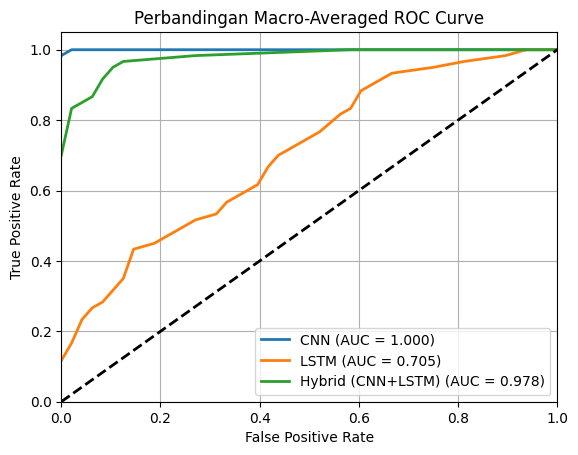

In [123]:
# Loop untuk setiap model
for model_name, y_pred_proba in models_proba.items():
    # Hitung macro-average ROC
    n_classes = y_test.shape[1]
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    
    macro_auc = auc(all_fpr, mean_tpr)

    # Plot ROC curve
    plt.plot(all_fpr, mean_tpr,
             label=f'{model_name} (AUC = {macro_auc:.3f})',
             linewidth=2)

# Plot garis referensi
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Perbandingan Macro-Averaged ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()